In [1]:
import pandas as pd
import numpy as np
import time
import spacy
import random
from pathlib import Path
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext import data 
import torchtext
from nltk.tokenize.treebank import TreebankWordDetokenizer
import itertools
import matplotlib.pyplot as plt

In [2]:
# Setting device on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':   
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

torch.backends.cudnn.deterministic = True

Using device: cuda

Tesla V100-SXM2-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [3]:
from google.colab import drive    
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
TEXT = data.Field(tokenize='spacy', lower=True, include_lengths= True)
LABEL = data.LabelField(dtype=torch.float)

# Map data to fields
fields = [('target', LABEL), ('id',None),('date',None),('query',None),
      ('name',None), ('text', TEXT),('category',None)]

# Apply field definition to create torch dataset
dataset = torchtext.data.TabularDataset(
        path="/content/drive/MyDrive/Colab Notebooks/tweet_final1.csv",
        format="CSV",
        fields=fields,
        skip_header=False)

In [5]:
(train_data, test_data, valid_data) = dataset.split(split_ratio=[0.8,0.1,0.1])

print("Number of train data: {}".format(len(train_data)))
print("Number of test data: {}".format(len(test_data)))
print("Number of validation data: {}".format(len(valid_data)))

Number of train data: 79866
Number of test data: 9983
Number of validation data: 9983


In [6]:
TEXT.build_vocab(train_data,max_size=30000)
LABEL.build_vocab(train_data)

In [7]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 30002
Unique tokens in LABEL vocabulary: 2


In [8]:
print(TEXT.vocab.freqs.most_common(20))

[('i', 49705), ('!', 44893), ('.', 39992), ('to', 28122), ('the', 26303), (',', 23761), ('a', 18965), ('my', 15767), ('it', 15242), ('you', 15173), ('and', 15044), ('is', 12249), ('?', 11986), ('in', 11032), ('...', 10951), ('for', 10797), ('of', 9269), ("'s", 9007), ('that', 8706), ("n't", 8640)]


In [9]:
del dataset

In [10]:
BATCH_SIZE = 500

# sort_within_batch sorts all the tensors within a batch by their lengths
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    device = device,
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True)

In [11]:
len(train_iterator)

160

In [12]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
                
        super().__init__()

        # 1. Feed the tweets in the embedding layer
        # padding_idx set to not learn the emedding for the <pad> token - irrelevant to determining sentiment
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        # 2. LSTM layer
        # returns the output and a tuple of the final hidden state and final cell state
        self.encoder = nn.LSTM(embedding_dim, 
                               hidden_dim, 
                               num_layers=n_layers,
                               bidirectional=bidirectional,
                               dropout=dropout)
        
        # 3. Fully-connected layer
        # Final hidden state has both a forward and a backward component concatenated together
        # The size of the input to the nn.Linear layer is twice that of the hidden dimension size
        self.predictor = nn.Linear(hidden_dim*2, output_dim)

        # Initialize dropout layer for regularization
        self.dropout = nn.Dropout(dropout)
      
    def forward(self, text, text_lengths):
        """
        The forward method is called when data is fed into the model.

        text - [tweet length, batch size]
        text_lengths - lengths of tweet
        """
        # embedded = [sentence len, batch size, emb dim]
        embedded = self.dropout(self.embedding(text))    
        #text_lengths = torch.as_tensor(text_lengths, dtype=torch.int64, device='cpu')
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)

        # output of encoder
        packed_output, (hidden, cell) = self.encoder(packed_embedded)

        # unpack sequence - transform packed sequence to a tensor
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # concat the final forward and backward hidden layers and apply dropout
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

        # hidden = [batch size, hid dim * num directions]

        return self.predictor(hidden)

In [13]:
def batch_accuracy(predictions, label):
    """
    Returns accuracy per batch.

    predictions - float
    label - 0 or 1
    """

    # Round predictions to the closest integer using the sigmoid function
    preds = torch.round(torch.sigmoid(predictions))
    # If prediction is equal to label
    correct = (preds == label).float()
    # Average correct predictions
    accuracy = correct.sum() / len(correct)

    return accuracy

def timer(start_time, end_time):
    """
    Returns the minutes and seconds.
    """

    time = end_time - start_time
    mins = int(time / 60)
    secs = int(time - (mins * 60))

    return mins, secs

In [14]:
def train(model, iterator, optimizer, criterion):

    clip=5    
    # Cumulated Training loss
    training_loss = 0.0
    # Cumulated Training accuracy
    training_acc = 0.0
    
    # Set model to training mode
    model.train()
    
    # For each batch in the training iterator
    for batch in iterator:
        
        # 1. Zero the gradients
        optimizer.zero_grad()
        
        # batch.text is a tuple (tensor, len of seq)
        text, text_lengths = batch.text
        text_lengths = torch.as_tensor(text_lengths, dtype=torch.int64, device='cpu')
        
        # 2. Compute the predictions
        predictions = model(text, text_lengths).squeeze(1)
        
        # 3. Compute loss
        loss = criterion(predictions, batch.target)
        
        # Compute accuracy
        accuracy = batch_accuracy(predictions, batch.target)
        
        # 4. Use loss to compute gradients
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # 5. Use optimizer to take gradient step
        optimizer.step()
        
        training_loss += loss.item()
        training_acc += accuracy.item()
    
    # Return the loss and accuracy, averaged across each epoch
    # len of iterator = num of batches in the iterator
    return training_loss / len(iterator), training_acc / len(iterator)

In [15]:
def evaluate(model, iterator, criterion):
    """
    Function to evaluate the loss and accuracy of validation and test sets.

    iterator - validation or test iterator
    """
    
    # Cumulated Training loss
    eval_loss = 0.0
    # Cumulated Training accuracy
    eval_acc = 0
    
    # Set model to evaluation mode
    model.eval()
    
    # Don't calculate the gradients
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            text_lengths = torch.as_tensor(text_lengths, dtype=torch.int64, device='cpu')
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.target)
            
            accuracy = batch_accuracy(predictions, batch.target)

            eval_loss += loss.item()
            eval_acc += accuracy.item()
        
    return eval_loss / len(iterator), eval_acc / len(iterator)

In [23]:
####(0.4, 100, 50, 'Adam', 0.01)
##(0.4, 256, 300, 'RMSprop', 0.001)

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
# 2 layers of biLSTM
N_LAYERS = 2
BIDIRECTIONAL = True
# Dropout probability
DROPOUT = 0.65
# Get pad token index from vocab
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTM(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

In [24]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

# Setting row in the embedding weights matrix to zero using the token index
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.9587,  0.4348, -0.5491,  ...,  1.1544,  1.6306, -0.0600],
        ...,
        [-0.4927,  1.2292, -1.0228,  ..., -0.3807,  0.8028,  2.4411],
        [ 2.6686,  1.2235,  0.5873,  ..., -1.2345,  0.2949, -1.0095],
        [-0.6841, -2.4760,  1.0966,  ..., -1.1145, -0.4963,  1.7798]])


In [25]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.RMSprop(model.parameters(),lr=0.001)

criterion = nn.BCEWithLogitsLoss()

# Use GPU
model = model.to(device)
criterion = criterion.to(device)

In [26]:
def training_plot(epoch_num, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list):
    plt.figure()
    plt.plot(range(epoch_num), train_loss_list, color='blue', linestyle='-', label='train_loss')
    plt.plot(range(epoch_num), valid_loss_list, color='green', linestyle='--', label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.yticks(np.arange(0, epoch_num, 0.25))
    plt.title('Training and validation loss')
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(range(epoch_num), train_acc_list, color='blue', linestyle='-', label='train_acc')
    plt.plot(range(epoch_num), valid_acc_list, color='green', linestyle='--', label='val_acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('Training and validation accuracy')
    plt.grid()
    plt.show()

Epoch 1:
	 Total Time: 0m 4s
	 Train Loss 0.62 | Train Accuracy: 65.66%
	 Validation Loss 0.54 | Validation Accuracy: 73.12%
Epoch 2:
	 Total Time: 0m 4s
	 Train Loss 0.55 | Train Accuracy: 71.85%
	 Validation Loss 0.56 | Validation Accuracy: 75.6%
Epoch 3:
	 Total Time: 0m 4s
	 Train Loss 0.52 | Train Accuracy: 74.22%
	 Validation Loss 0.52 | Validation Accuracy: 76.83%
Epoch 4:
	 Total Time: 0m 5s
	 Train Loss 0.5 | Train Accuracy: 75.73%
	 Validation Loss 0.48 | Validation Accuracy: 77.98%
Epoch 5:
	 Total Time: 0m 4s
	 Train Loss 0.49 | Train Accuracy: 76.74%
	 Validation Loss 0.47 | Validation Accuracy: 78.72%
Epoch 6:
	 Total Time: 0m 4s
	 Train Loss 0.47 | Train Accuracy: 77.6%
	 Validation Loss 0.47 | Validation Accuracy: 78.87%
Epoch 7:
	 Total Time: 0m 4s
	 Train Loss 0.46 | Train Accuracy: 78.31%
	 Validation Loss 0.46 | Validation Accuracy: 79.39%
Epoch 8:
	 Total Time: 0m 4s
	 Train Loss 0.45 | Train Accuracy: 79.01%
	 Validation Loss 0.46 | Validation Accuracy: 79.68%
Epo

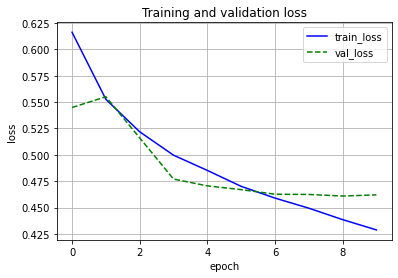

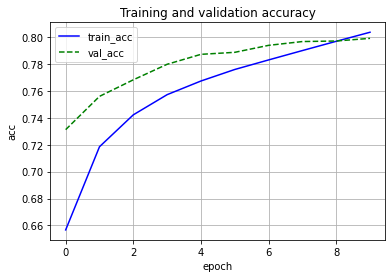

In [27]:
# Number of epochs
NUM_EPOCHS = 10

# Lowest validation lost
best_valid_loss = float('inf')
train_loss_list = []
train_acc_list  = []
valid_loss_list = []
valid_acc_list  = []

for epoch in range(NUM_EPOCHS):

    start_time = time.time()
    
    # Evaluate training loss and accuracy
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    # Evaluate validation loss and accuracy
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    mins, secs = timer(start_time, end_time)
    
    # At each epoch, if the validation loss is the best
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # Save the parameters of the model
        torch.save(model.state_dict(), 'lstm-self.pt')

    print("Epoch {}:".format(epoch+1))
    print("\t Total Time: {}m {}s".format(mins, secs))
    print("\t Train Loss {} | Train Accuracy: {}%".format(round(train_loss, 2), round(train_acc*100, 2)))
    print("\t Validation Loss {} | Validation Accuracy: {}%".format(round(valid_loss, 2), round(valid_acc*100, 2)))

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)

training_plot(NUM_EPOCHS, train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)
#plot_history(train_loss_list, valid_loss_list, title='loss')
#plot_history(train_acc_list, valid_acc_list, title='acc')

In [28]:
# Load the model with the best validation loss
model.load_state_dict(torch.load('lstm-self.pt'))

# Evaluate test loss and accuracy
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print("Test Loss: {} | Test Acc: {}%".format(round(test_loss, 2), round(test_acc*100, 2)))

Test Loss: 0.45 | Test Acc: 80.14%


In [ ]:
##Grid Search to find best hyperparameters

GRID_DROPOUT = [.5, .75, .4]
HIDDEN_DIM = [64,100,256]
GRID_EMBED_DIM = [100,200,300]
GRID_OPT_SELECT = ["Adam","RMSprop"]
#GRID_LR = [0.01,0.001,0.0001]
GRID_LR = [0.1,0.01,0.001]

GRID_TOTAL = [] 

for perm in itertools.product(GRID_DROPOUT, HIDDEN_DIM, GRID_EMBED_DIM, GRID_OPT_SELECT, GRID_LR):
    GRID_TOTAL.append(perm)

len(GRID_TOTAL) ## 162 models
GRID_MODELS = []
GRID_OPT = []

for i in range(len(GRID_TOTAL)):
    
    DROPOUT = GRID_TOTAL[i][0]
    HIDDEN_DIM = GRID_TOTAL[i][1]
    GRID_EMBED_DIM = GRID_TOTAL[i][2]
    OPT = GRID_TOTAL[i][3]
    LR = GRID_TOTAL[i][4]
    
    GRID_MODELS.append(LSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX).to(device))
    GRID_OPT.append(eval("optim."+OPT)(GRID_MODELS[i].parameters(),LR))

In [ ]:
NUM_EPOCHS = 10
GRID_TRACKER = []
Val_Tracker = []
best_valid_loss = float('inf')
for i in range(len(GRID_MODELS)):
  print("Params", GRID_MODELS[i].parameters)
  for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    criterion = nn.BCEWithLogitsLoss()
    criterion.to(device)
    train_loss, train_acc = train(GRID_MODELS[i], train_iterator, GRID_OPT[i], criterion)
    valid_loss, valid_acc = evaluate(GRID_MODELS[i], valid_iterator, criterion)
    # Save val_acc
    Val_Tracker.append(valid_acc)
       
    end_time = time.time()
    mins, secs = timer(start_time,end_time)
    print("Epoch {}:".format(epoch+1))
    print(GRID_MODELS[i])
    #print(GRID_TOTAL[GRID_TRACKER.index(np.max(GRID_TRACKER))])
    print("\t Total Time: {}m {}s".format(mins, secs))
    print("\t Train Loss {} | Train Accuracy: {}%".format(round(train_loss, 2), round(train_acc*100, 2)))
    print("\t Validation Loss {} | Validation Accuracy: {}%".format(round(valid_loss, 2), round(valid_acc*100, 2)))
  GRID_TRACKER.append(np.max([Val_Tracker[x] for x in range(len(Val_Tracker))]))

Streaming output truncated to the last 5000 lines.
  (embedding): Embedding(25002, 100, padding_idx=1)
  (encoder): LSTM(100, 64, num_layers=2, dropout=0.4, bidirectional=True)
  (predictor): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
	 Total Time: 0m 3s
	 Train Loss 0.79 | Train Accuracy: 52.73%
	 Validation Loss 0.79 | Validation Accuracy: 52.56%
Epoch 10:
LSTM(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (encoder): LSTM(100, 64, num_layers=2, dropout=0.4, bidirectional=True)
  (predictor): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
	 Total Time: 0m 3s
	 Train Loss 0.75 | Train Accuracy: 52.28%
	 Validation Loss 0.69 | Validation Accuracy: 56.57%
Params <bound method Module.parameters of LSTM(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (encoder): LSTM(100, 64, num_layers=2, dropout=0.4, bidirectional=True)
  (predictor): Linear(in_features=128, out_features=1

In [ ]:
## dropout, hidden_dim, embedding dim, opt, LR
####(0.4, 100, 50, 'Adam', 0.001)
GRID_TOTAL[GRID_TRACKER.index(np.max(GRID_TRACKER))] 
np.max(GRID_TRACKER)
print(GRID_TOTAL[GRID_TRACKER.index(np.max(GRID_TRACKER))])

print("mean: %f and std dev: %f " % (np.mean(GRID_TRACKER), np.std(GRID_TRACKER)))

(0.4, 256, 300, 'RMSprop', 0.001)
mean: 0.802034 and std dev: 0.011412 


In [29]:
nlp = spacy.load('en')

def predict(model, text, tokenized=True):
    """
    Given a tweet, predict the sentiment.

    text - a string or a a list of tokens
    tokenized - True if text is a list of tokens, False if passing in a string
    """

    # Sets the model to evaluation mode
    model.eval()

    if tokenized == False:
        # Tokenizes the sentence
        tokens = [token.text for token in nlp.tokenizer(text)]
    else:
        tokens = text

    # Index the tokens by converting to the integer representation from the vocabulary
    indexed_tokens = [TEXT.vocab.stoi[t] for t in tokens]
    # Get the length of the text
    length = [len(indexed_tokens)]
    # Convert the indices to a tensor
    tensor = torch.LongTensor(indexed_tokens).to(device)
    # Add a batch dimension by unsqueezeing
    tensor = tensor.unsqueeze(1)
    # Converts the length into a tensor
    length_tensor = torch.LongTensor(length)
    # Convert prediction to be between 0 and 1 with the sigmoid function
    prediction = torch.sigmoid(model(tensor, length_tensor))

    # Return a single value from the prediction
    return prediction.item()

In [30]:
print("Tweet: {}".format(TreebankWordDetokenizer().detokenize(test_data[20].text)))

print("Prediction: {}".format(round(predict(model, test_data[20].text), 2)))

print("True Label: {}".format(test_data[10].target))

Tweet: looks can be deceiving i guess.
Prediction: 0.09
True Label: 1


In [31]:
# List to append data to
d = []


for idx in range(10):

    # Detokenize the tweets from the test set
    tweet = TreebankWordDetokenizer().detokenize(test_data[idx].text)
                                                 
    # Append tweet, prediction, and true label
    d.append({'Tweet': tweet, 'Prediction': predict(model, test_data[idx].text), 'True Label': test_data[idx].target})

# Convert list to dataframe
pd.DataFrame(d)

,Tweet,Prediction,True Label
0,working! woo hooo wish i was somewhere i could...,0.107630,1
1,i'm finished school...forever!,0.665726,0
2,"if it helps, i'm (just) gen y and just turned ...",0.628894,1
3,oh btw i wos at coles with achok gettin sum bu...,0.208241,0
4,picked up my givenchy and christian louboutin ...,0.042274,0
5,morning all!! what an incredible start to the ...,0.881124,1
6,general motors its time to be fair to the amer...,0.856644,0
7,"good morning twitterland, happy sunday 2 u all...",0.757900,1
8,we might be going hiking tonight in the south ...,0.890227,1
9,drink lots of orange juice,0.802500,1


In [32]:
testdf = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/trump_tweets_v3.csv",
                encoding='latin-1', error_bad_lines=False)

In [33]:
testdf.head(0)

,Tweet,Date,Subjectivity,Polarity,Sentiment


In [34]:
fields = [('Tweet', TEXT), ('Subjectivity',None),('Date',None),('Polarity',None),
      ('Sentiment',LABEL)]

# Apply field definition to create torch dataset
testdf = torchtext.data.TabularDataset(
        path="/content/drive/MyDrive/Colab Notebooks/trump_tweets_v3.csv",
        format="CSV",
        fields=fields,
        skip_header=True)

In [35]:
testdf.fields

{'Date': None,
 'Polarity': None,
 'Sentiment': <torchtext.data.field.LabelField at 0x7f4e244e1828>,
 'Subjectivity': None,
 'Tweet': <torchtext.data.field.Field at 0x7f4eda155cc0>}

In [36]:
#testdf.iloc[0].Tweet
testdf[1].Tweet

['read',
 ':',
 'letter',
 'to',
 'surveillance',
 'court',
 'obtained',
 'by',
 'cbs',
 'news',
 'questions',
 'where',
 'there',
 'will',
 'be',
 'further',
 'disciplinary',
 'action',
 'and',
 'choâ\x80',
 '¦']

In [37]:
len(testdf)

5943

In [38]:
# List to append data to
d = []


for idx in range(len(testdf)):

    # Detokenize the tweets from the test set
    tweet = TreebankWordDetokenizer().detokenize(testdf[idx].Tweet)
                                                 
    # Append tweet, prediction, and true label
    d.append({'Tweet': tweet, 'Prediction': predict(model, testdf[idx].Tweet), 'True Label': testdf[idx].Sentiment})

# Convert list to dataframe
newdf = pd.DataFrame(d)

In [39]:
newdf

,Tweet,Prediction,True Label
0,i was thrilled to be back in the great city of...,0.967820,Positive
1,read: letter to surveillance court obtained by...,0.488219,Positive
2,the unsolicited mail in ballot scam is a major...,0.194328,Positive
3,very friendly telling of events here about com...,0.595052,Positive
4,president announced historic steps to protec...,0.106739,Positive
...,...,...,...
5938,one of my greatest honors was to have gotten c...,0.600282,Positive
5939,magnificent trump- keeping his promises ðº...,0.591756,Positive
5940,congratulations sleepy joe! you just won stupi...,0.849551,Negative
5941,dear stupid people- peace is a good thingputin...,0.028898,Negative


In [40]:
newdf.to_csv("predict_lstm.csv", header=True, index=False)

In [41]:
positive = newdf[newdf['True Label'] == 'Positive']
negative = newdf[newdf['True Label']== 'Negative']
total = positive.shape[0] + negative.shape[0]

print(str(positive.shape[0]/(total)*100) + " % of positive tweets")
print(str(negative.shape[0]/(total)*100) + " % of negative tweets")

70.75551068483931 % of positive tweets
29.244489315160692 % of negative tweets


In [42]:
positive.shape[0]
negative.shape[0]
total

5943

In [43]:
newdf.shape[0]

5943

In [44]:
positivePred = newdf[newdf['Prediction'] >= 0.5]
negativePred = newdf[newdf['Prediction']< 0.5]
#neutralPred = newdf[newdf['Prediction'] == 0.65]
print(str(positivePred.shape[0]/(newdf.shape[0])*100) + " % of positive tweets")
print(str(negativePred.shape[0]/(newdf.shape[0])*100) + " % of negative tweets")
#print(str(neutralPred.shape[0]/(newdf.shape[0])*100) + " % of neutral tweets")
#print(str(positivePred.shape[0]/(total)*100) + " % of positive tweets")

70.85646979639913 % of positive tweets
29.143530203600875 % of negative tweets


In [45]:
newdf.head(10)
newdf.tail(10)
newdf.dtypes

Tweet          object
Prediction    float64
True Label     object
dtype: object